# Imports

In [111]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



In [2]:
data = pd.read_csv('Emotion_final.csv')

In [80]:
# nltk.download('stopwords') Charger les StopWords dans NLTK
# nltk.download('punkt') Charger la punctuation dans NLTK
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...


True

In [26]:
# Spécifiez la langue appropriée
langue = 'english'  # Remplacez 'langue' par la langue appropriée (par exemple, 'english' pour l'anglais)

# Ajouter la virgule à la liste des stopwords pour la langue spécifiée
stopwords_list = set(stopwords.words(langue))
stopwords_list.add(',')

# Utilisez maintenant stopwords_list comme votre liste de stopwords incluant la virgule


# Consignes

A partir du jeu de données et à l'aide la librairie NLTK ou de la librairie Spacy, vous pouvez même essayez texthero:
- étudier la répartition des textes par émotions
- identifiez quels mots sont susceptibles d'être des stopword
- pour chaque sentiment, identifiez les 30 mots les plus courants pour chaque sentiment en dehors des stopwords
- A partir de ces 30 mots, définissez une métrique de proximité entre les sentiments et affichez-la sur une matrice type heatmap.
- Créer deux premiers modèles (Bag of words et TF IDF) en gérant les étapes de tokenisation, de gestion de la ponctuation, des émojis, des stopwords, de lemmatisation ou de streaming.

Le rendu du premier de temps se fera dans un notebook.


# Appercu

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [6]:
data.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


In [7]:
data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
data.nunique()

Text       21405
Emotion        6
dtype: int64

In [9]:
data['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

# Analyse

### Etudier la répartition des textes par émotions

In [10]:
grouped = data.groupby("Emotion")

In [11]:
counts = grouped.count()

In [12]:
percentage = counts / len(data)

In [13]:
percentage.round(2)

,Text
Emotion,
anger,0.14
fear,0.12
happy,0.33
love,0.08
sadness,0.29
surprise,0.04


### Identifiez quels mots sont susceptibles d'être des stopword

In [14]:
all_text = ' '.join(data['Text'].tolist())


In [15]:
tokens = word_tokenize(all_text)


In [16]:
stopwords_list = set(stopwords.words('english'))  

# Remplacez 'langue' par la langue appropriée (par exemple, 'english' pour l'anglais)


In [17]:
suspected_stopwords = [word.lower() for word in tokens if word.lower() in stopwords_list]


In [18]:
word_counts = pd.Series(suspected_stopwords).value_counts()

word_counts

i             32529
and           12721
to            11835
the           11808
a              8333
              ...  
ain               3
theirs            3
ours              2
weren             2
yourselves        2
Name: count, Length: 149, dtype: int64

### Pour chaque sentiment : 
 - identifiez les 30 mots les plus courants en dehors des stopwords

In [27]:
def get_top_words(text, n=30):
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]
    word_counts = pd.Series(filtered_tokens).value_counts().rename_axis('Mots').reset_index(name='Occurrences')
    top_words = word_counts.head(n)
    return top_words

# Créer un dictionnaire pour stocker les données des émotions
emotion_data = {}

# Itérer sur chaque émotion et obtenir les mots les plus courants
for emotion in data['Emotion'].unique():
    group = data[data['Emotion'] == emotion]
    top_words = get_top_words(' '.join(group['Text'].tolist()))
    emotion_data[emotion] = top_words['Mots']

# Créer un DataFrame à partir du dictionnaire des données d'émotion
text_top30_words = pd.DataFrame(emotion_data)

# Transposer le DataFrame pour échanger les index et les colonnes
# text_top30_words = text_top30_words.transpose()

# # Renommer les colonnes de 1 à 30 avec les numéros correspondants
# text_top30_words.columns = range(1, 31)

# Afficher le DataFrame
noms_nouveaux = {'sadness': 'sadness_word', 
                 'anger': 'anger_word', 
                 'love': 'love_word', 
                 'surprise': 'surprise_word', 
                 'fear': 'fear_word', 
                 'happy': 'happy_word'}
text_top30_words.rename(columns=noms_nouveaux, inplace=True)

# Afficher le DataFrame avec les colonnes renommées
text_top30_words

,sadness_word,anger_word,love_word,surprise_word,fear_word,happy_word
0,feel,feel,feel,feel,feel,feel
1,feeling,feeling,feeling,feeling,feeling,feeling
2,like,like,like,like,im,like
3,im,im,im,im,like,im
4,really,really,love,amazed,little,really
5,know,get,really,curious,bit,time
6,get,people,know,impressed,know,know
7,would,know,sweet,overwhelmed,really,get
8,time,time,time,surprised,anxious,make
9,little,little,loving,funny,time,people


In [28]:
def get_top_words(text, n=30):
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]
    word_counts = pd.Series(filtered_tokens).value_counts().rename_axis('Mots').reset_index(name='Occurrences')
    top_words = word_counts.head(n)
    return top_words

emotion_data = {}

# Itérer sur chaque émotion et obtenir les mots les plus courants
for emotion in data['Emotion'].unique():
    group = data[data['Emotion'] == emotion]
    top_words = get_top_words(' '.join(group['Text'].tolist()))
    emotion_data[emotion] = top_words['Occurrences']

# Créer un DataFrame à partir du dictionnaire des données d'émotion
number_top30_words = pd.DataFrame(emotion_data)

# number_top30_words = number_top30_words.transpose()

# Afficher le DataFrame
noms_nouveaux = {'sadness': 'sadness_num', 
                 'anger': 'anger_num', 
                 'love': 'love_num', 
                 'surprise': 'surprise_num', 
                 'fear': 'fear_num', 
                 'happy': 'happy_num'}
number_top30_words.rename(columns=noms_nouveaux, inplace=True)

# Afficher le DataFrame avec les colonnes renommées
number_top30_words

,sadness_num,anger_num,love_num,surprise_num,fear_num,happy_num
0,4095,1803,1180,464,1483,4948
1,1924,923,471,261,926,1956
2,1078,479,393,121,383,1266
3,875,426,251,113,322,1007
4,352,171,119,83,194,381
5,344,154,112,72,143,370
6,289,150,101,72,139,323
7,273,149,84,69,129,311
8,270,146,82,68,126,276
9,267,136,82,68,119,266


### A partir de ces 30 mots : 
 - définissez une métrique de proximité entre les sentiments et affichez-la sur une matrice type heatmap.


In [29]:
concat_data = pd.concat([number_top30_words, text_top30_words], axis=1)

# Définir les émotions comme nouvel index
# concat_data = concat_data.set_index('Emotion')

# # Réinitialiser l'index
# concat_data = concat_data.reset_index()

In [62]:
concat_data

,sadness_num,anger_num,love_num,surprise_num,fear_num,happy_num,sadness_word,anger_word,love_word,surprise_word,fear_word,happy_word
0,4095,1803,1180,464,1483,4948,feel,feel,feel,feel,feel,feel
1,1924,923,471,261,926,1956,feeling,feeling,feeling,feeling,feeling,feeling
2,1078,479,393,121,383,1266,like,like,like,like,im,like
3,875,426,251,113,322,1007,im,im,im,im,like,im
4,352,171,119,83,194,381,really,really,love,amazed,little,really
5,344,154,112,72,143,370,know,get,really,curious,bit,time
6,289,150,101,72,139,323,get,people,know,impressed,know,know
7,273,149,84,69,129,311,would,know,sweet,overwhelmed,really,get
8,270,146,82,68,126,276,time,time,time,surprised,anxious,make
9,267,136,82,68,119,266,little,little,loving,funny,time,people


In [63]:
# Liste des colonnes numériques et des colonnes correspondantes "_word"
numeric_columns = ['sadness_num', 'anger_num', 'love_num', 'surprise_num', 'fear_num', 'happy_num']
word_columns = ['sadness_word', 'anger_word', 'love_word', 'surprise_word', 'fear_word', 'happy_word']

# Création du nouvel index à partir des colonnes "_word"
new_index = concat_data[word_columns].values.flatten()

# Suppression des doublons et tri du nouvel index
new_index = sorted(set(new_index))

# Création d'un DataFrame vide avec le nouvel index et les colonnes numériques
pivoted_df = pd.DataFrame(index=new_index, columns=numeric_columns)

# Remplissage des valeurs manquantes avec 0
pivoted_df.fillna(0, inplace=True)

# Remplissage des valeurs numériques correspondantes
for index, row in concat_data.iterrows():
    for num_col, word_col in zip(numeric_columns, word_columns):
        word = row[word_col]
        value = row[num_col]
        pivoted_df.loc[word, num_col] = value

pivoted_df

,sadness_num,anger_num,love_num,surprise_num,fear_num,happy_num
accepted,0,0,60,0,0,0
afraid,0,0,0,0,85,0
agitated,0,0,0,0,84,0
amazed,0,0,0,83,0,0
amazing,0,0,0,56,0,0
...,...,...,...,...,...,...
want,237,129,80,0,95,250
way,162,102,0,0,0,0
weird,0,0,0,67,79,0
well,0,0,0,0,0,187


In [67]:
final_form = pivoted_df.reset_index().rename(columns={'index': 'Words'})

In [72]:
final_form

,Words,sadness_num,anger_num,love_num,surprise_num,fear_num,happy_num
0,accepted,0,0,60,0,0,0
1,afraid,0,0,0,0,85,0
2,agitated,0,0,0,0,84,0
3,amazed,0,0,0,83,0,0
4,amazing,0,0,0,56,0,0
...,...,...,...,...,...,...,...
72,want,237,129,80,0,95,250
73,way,162,102,0,0,0,0
74,weird,0,0,0,67,79,0
75,well,0,0,0,0,0,187


In [66]:
# final_form.to_csv('sorted_final',index=False)

In [70]:
df_transposed = final_form.transpose()

# Afficher le nouveau dataset
df_transposed

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
Words,accepted,afraid,agitated,amazed,amazing,angry,anxious,back,bit,bothered,...,tender,terrified,things,think,time,want,way,weird,well,would
sadness_num,0,0,0,0,0,0,0,167,220,0,...,0,0,194,222,270,237,162,0,0,273
anger_num,0,0,0,0,0,116,0,0,103,81,...,0,0,105,111,146,129,102,0,0,118
love_num,60,0,0,0,0,0,0,0,0,0,...,64,0,0,0,82,80,0,0,0,62
surprise_num,0,0,0,83,56,0,0,0,40,0,...,0,0,0,33,44,0,0,67,0,35
fear_num,0,85,84,0,0,0,126,0,143,0,...,0,89,77,89,119,95,0,79,0,94
happy_num,0,0,0,0,0,0,0,0,0,0,...,0,0,0,239,370,250,0,0,187,265


In [75]:
# Calculer la matrice de similarité en utilisant la similarité cosinus
similarity_matrix = pd.DataFrame(cosine_similarity(pivoted_df.values), index=pivoted_df.index, columns=pivoted_df.index)

# Masquer (remplacer) les valeurs égales à zéro par NaN
similarity_matrix_filtered = similarity_matrix.mask(similarity_matrix == 0)

# Afficher la matrice de similarité filtrée
similarity_matrix_filtered

,accepted,afraid,agitated,amazed,amazing,angry,anxious,back,bit,bothered,...,tender,terrified,things,think,time,want,way,weird,well,would
accepted,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,0.162724,0.206055,NaN,NaN,NaN,0.149243
afraid,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,0.502271,NaN,...,NaN,1.000000,0.329560,0.249019,0.236148,0.244690,NaN,0.762653,NaN,0.226271
agitated,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,0.502271,NaN,...,NaN,1.000000,0.329560,0.249019,0.236148,0.244690,NaN,0.762653,NaN,0.226271
amazed,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,0.140495,NaN,...,NaN,NaN,NaN,0.092333,0.087315,NaN,NaN,0.646807,NaN,0.084250
amazing,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,0.140495,NaN,...,NaN,NaN,NaN,0.092333,0.087315,NaN,NaN,0.646807,NaN,0.084250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
want,0.206055,0.244690,0.244690,NaN,NaN,0.332264,0.244690,0.610438,0.714806,0.332264,...,0.206055,0.244690,0.736817,0.973899,0.987444,1.000000,0.693607,0.186614,0.643922,0.992396
way,NaN,NaN,NaN,NaN,NaN,0.532813,NaN,0.846233,0.846664,0.532813,...,NaN,NaN,0.942090,0.691116,0.607780,0.693607,1.000000,NaN,NaN,0.707442
weird,NaN,0.762653,0.762653,0.646807,0.646807,NaN,0.762653,NaN,0.473932,NaN,...,NaN,0.762653,0.251340,0.249637,0.236575,0.186614,NaN,1.000000,NaN,0.227060
well,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.668715,0.734241,0.643922,NaN,NaN,1.000000,0.637892


In [60]:


# Calculer la matrice de similarité en utilisant la similarité cosinus
similarity_matrix = pd.DataFrame(cosine_similarity(pivoted_df.values), index=pivoted_df.index, columns=pivoted_df.index)

# Masquer (remplacer) les valeurs égales à zéro par NaN
similarity_matrix_filtered = similarity_matrix.mask(similarity_matrix == 0)

# Afficher la matrice de similarité filtrée
similarity_matrix_filtered



,accepted,afraid,agitated,amazed,amazing,angry,anxious,back,bit,bothered,...,tender,terrified,things,think,time,want,way,weird,well,would
accepted,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,0.162724,0.206055,NaN,NaN,NaN,0.149243
afraid,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,0.502271,NaN,...,NaN,1.000000,0.329560,0.249019,0.236148,0.244690,NaN,0.762653,NaN,0.226271
agitated,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,0.502271,NaN,...,NaN,1.000000,0.329560,0.249019,0.236148,0.244690,NaN,0.762653,NaN,0.226271
amazed,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,0.140495,NaN,...,NaN,NaN,NaN,0.092333,0.087315,NaN,NaN,0.646807,NaN,0.084250
amazing,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,0.140495,NaN,...,NaN,NaN,NaN,0.092333,0.087315,NaN,NaN,0.646807,NaN,0.084250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
want,0.206055,0.244690,0.244690,NaN,NaN,0.332264,0.244690,0.610438,0.714806,0.332264,...,0.206055,0.244690,0.736817,0.973899,0.987444,1.000000,0.693607,0.186614,0.643922,0.992396
way,NaN,NaN,NaN,NaN,NaN,0.532813,NaN,0.846233,0.846664,0.532813,...,NaN,NaN,0.942090,0.691116,0.607780,0.693607,1.000000,NaN,NaN,0.707442
weird,NaN,0.762653,0.762653,0.646807,0.646807,NaN,0.762653,NaN,0.473932,NaN,...,NaN,0.762653,0.251340,0.249637,0.236575,0.186614,NaN,1.000000,NaN,0.227060
well,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.668715,0.734241,0.643922,NaN,NaN,1.000000,0.637892


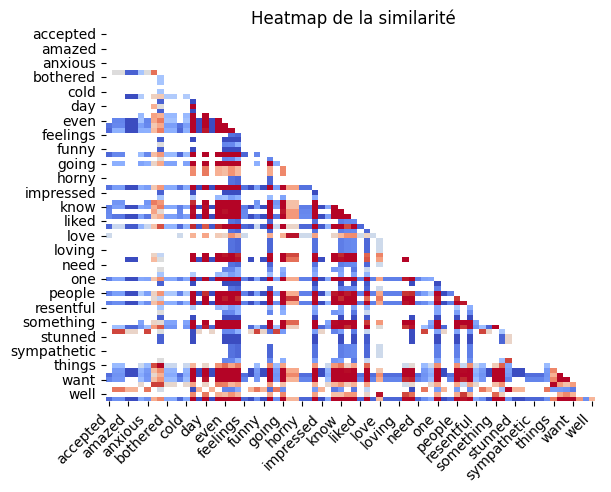

In [61]:
# Calculer la matrice de similarité en utilisant la similarité cosinus
similarity_matrix = pd.DataFrame(cosine_similarity(pivoted_df.values), index=pivoted_df.index, columns=pivoted_df.index)

# Masquer (remplacer) les valeurs égales à zéro par NaN
similarity_matrix_filtered = similarity_matrix.mask(similarity_matrix == 0)

# Créer un masque pour afficher seulement la moitié supérieure de la heatmap
mask = np.triu(np.ones_like(similarity_matrix_filtered, dtype=bool))

# Exclure les valeurs égales à 1
similarity_matrix_filtered = similarity_matrix_filtered.mask(similarity_matrix_filtered == 1)

# Créer la heatmap avec les options spécifiées
sns.heatmap(similarity_matrix_filtered, cmap='coolwarm', annot=False, mask=mask, vmin=0.1, vmax=0.9, cbar=False)
plt.title('Heatmap de la similarité')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


### Créer deux premiers pre-processing (Bag of words et TF IDF) 
- en gérant les étapes de tokenisation, 
- de gestion de la ponctuation, des émojis, des stopwords, 
- de lemmatisation ou de steaming 
- puis implémenter un modèle de machine learning de scikit learn.

In [95]:
data=pd.read_csv('Emotion_final.csv')

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


#### Bag Of Words

In [112]:

# Étape 3 : Prétraitement des données
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_data(text):
    # Tokenisation
    tokens = nltk.word_tokenize(text.lower())
    
    # Suppression de la ponctuation
    tokens = [token for token in tokens if token.isalnum()]
    
    # Suppression des stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatisation
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Reconstitution du texte prétraité
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data['preprocessed_text'] = data['Text'].apply(preprocess_data)

# Étape 4 : Création du Bag of Words
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(data['preprocessed_text'])
feature_names = vectorizer.get_feature_names_out()


# Étape 6 : Modèle de machine learning
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, data['Emotion'], test_size=0.2, random_state=42)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)


Accuracy: 0.8946877912395154


In [114]:

# Sauvegarder le modèle
# with open("model.pkl", "wb") as file:
#     pickle.dump(model, file)

#### TF-IDF    
    

In [100]:

# Étape 3 : Prétraitement des données
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_data(text):
    # Tokenisation
    tokens = nltk.word_tokenize(text.lower())
    
    # Suppression de la ponctuation
    tokens = [token for token in tokens if token.isalnum()]
    
    # Suppression des stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatisation
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Reconstitution du texte prétraité
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data['preprocessed_text'] = data['Text'].apply(preprocess_data)


# Étape 5 : Création du TF-IDF
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data['preprocessed_text'])
feature_names = vectorizer.get_feature_names_out()

# Étape 6 : Modèle de machine learning
X_train, X_test, y_train, y_test = train_test_split(tfidf, data['Emotion'], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', accuracy)


Accuracy: 0.8725535880708295


### Appliquer le model au dataset

In [118]:

# Charger le modèle
with open("model.pkl", "rb") as file:
    model = pickle.load(file)

# Charger le dataset
df = pd.read_csv("Emotion_final.csv")

# Fonction de prétraitement des données
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_data(text):
    # Tokenisation
    tokens = nltk.word_tokenize(text.lower())

    # Suppression de la ponctuation
    tokens = [token for token in tokens if token.isalnum()]

    # Suppression des stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatisation
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Reconstitution du texte prétraité
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Prétraitement des données
df['preprocessed_text'] = df['Text'].apply(preprocess_data)

# Création du Bag of Words
bag_of_words = vectorizer.transform(df['preprocessed_text'])

# Prédiction du modèle
predictions = model.predict(bag_of_words)

# Calcul de l'exactitude
accuracy = accuracy_score(df['Emotion'], predictions)
rounded_accuracy = round(accuracy, 2)

# Ajout de l'exactitude au dataset
df['Confidence'] = rounded_accuracy


# Enregistrer le dataset mis à jour
df.to_csv("Predicted_Data.csv", index=False)
